In [1118]:
# Deniz N. Cakan
from natsort import natsorted
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colorbar
import seaborn as sns
import warnings
from tqdm import tqdm
from matplotlib import style
import numpy as np
import h5py as h5
import h5py
import matplotlib.pyplot as plt
import os
from apstools import s2, xrf
import frgtools.plotting as frgplt
import frgtools.misc as frgm 
import mendeleev as men
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from scipy import stats

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['axes.linewidth'] = 1.75 #set the value globally
import matplotlib.colors as colors
import xraydb


from matplotlib import patches
from matplotlib.patches import Rectangle

def notick(ax):
    for ax_ in ax:
        ax_.set_yticklabels([])
        ax_.set_xticklabels([])  
        ax_.tick_params(left=False, bottom= False)

from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

def rubberband(x, y):
    # Find the convex hull
    v = ConvexHull(np.array(list(zip(x, y)))).vertices
    # Rotate convex hull vertices until they start from the lowest one
    v = np.roll(v, -v.argmin())
    # Leave only the ascending part
    v = v[:v.argmax()]

    # Create baseline using linear interpolation between vertices
    return np.interp(x, x[v], y[v])

def open_XEOL_h5(filename):
    out = {}
    with h5py.File(filename, "r") as dat:
#         out['scannum'] = dat['scannum'] # only added in later in scan list
        out['energy'] = dat['energy'][:]
        out['time_data'] = dat['time_data'][:]
        out['bg'] = dat['bg_data'][:]  
        out['data'] = dat['data'][:]#- savgol_filter(out['bg'], 1021, 1)

        for n in range(out['data'].shape[0]):
            for k in range(out['data'].shape[1]):
                out['data'][n,k,:] = (out['data'][n,k,:] - savgol_filter(out['bg'], 1021, 1) )  / out['time_data'][n,k] #converting signal to counts per second, to factor in spectrometer dwell time noise
        
    
        out['max'] = out['data'].max(axis = 2)
        out['peakPL'] = out['energy'][np.argmax(out['data'], axis = 2)]
        out['data_0d'] = np.sum(np.sum(out['data'],axis=0), axis=0)
        
        window = 101
        out['data_smoothed'] = savgol_filter(out['data_0d'], window, 1)  #- rubberband(out['energy'], savgol_filter(out['data_0d'], window, 1))
    
    # applying same signal processing per pixel will enable color maps to make sense
        out['data_pixel_smoothed'] = np.zeros(out['data'].shape)
        for n in range(out['data'].shape[0]):
            for k in range(out['data'].shape[1]):
                out['data_pixel_smoothed'][n,k,:] = savgol_filter(out['data'][n,k,:], window, 1) #/out['time_data'][n,k] #- rubberband(out['energy'], savgol_filter(out['data'][n,k,:], window, 1))
                
        out['peakPL_pixel_smoothed'] = out['energy'][np.argmax(out['data_pixel_smoothed'], axis = 2)]
        out['max_pixel_smoothed'] = out['data_pixel_smoothed'].max(axis = 2)
        out['data_0d_pixel_smoothed'] = np.sum(np.sum(out['data_pixel_smoothed'],axis=0), axis=0)

    return out

In [1101]:
root = '/Volumes/GoogleDrive/Shared drives/FenningLab2/Projects/APS/APS_202112_2IDD/xeol_test'

In [1102]:
fids = []
for f in frgm.listdir(root, display=False):
    if 'control' in f and '_rgb' not in f:
        continue
    fids.append(f)
# print('should be 21 for inorganic 16 for hybrid, 6-roi, 10-xbic-wf, 5-xrf-wf')

print('total: '+str(len(fids)))
fids = natsorted(fids)



total: 78


In [1103]:
# for number, letter in enumerate(fids):
#     print(letter, number)

In [1104]:
# test = open_XEOL_h5(fids[73])

In [1114]:
test = open_XEOL_h5(fids[77])


In [781]:
np.mean(test['time_data'])

9.919656432754167

In [835]:
test.keys()

dict_keys(['energy', 'time_data', 'bg', 'data', 'max', 'peakPL', 'data_0d', 'data_smoothed', 'data_pixel_smoothed'])

In [853]:
test['data_pixel_smoothed'].shape

(31, 31, 2048)

In [1116]:
##run this once to turn on interactive plots 
%matplotlib qt

import hyperspy.api as hs

In [1117]:
# s = hs.signals.Signal1D(test['data']) #for interactive plot, need to figure out how to define x-axis
s = hs.signals.Signal1D(test['data']) #for interactive plot, need to figure out how to define x-axis

s.plot()

In [905]:
1240/test['energy'][1484-100]

1.5448825764654581

In [901]:
1240/test['energy'][1484-200]

1.641710026346798

In [906]:
test_1 = new_data[:,:,1264:1384]
test_2 = np.sum(new_data, axis=2)

In [908]:
test_1 = test['data_pixel_smoothed'][:,:,1264:1384]
test_2 = np.sum(test_1, axis=2)

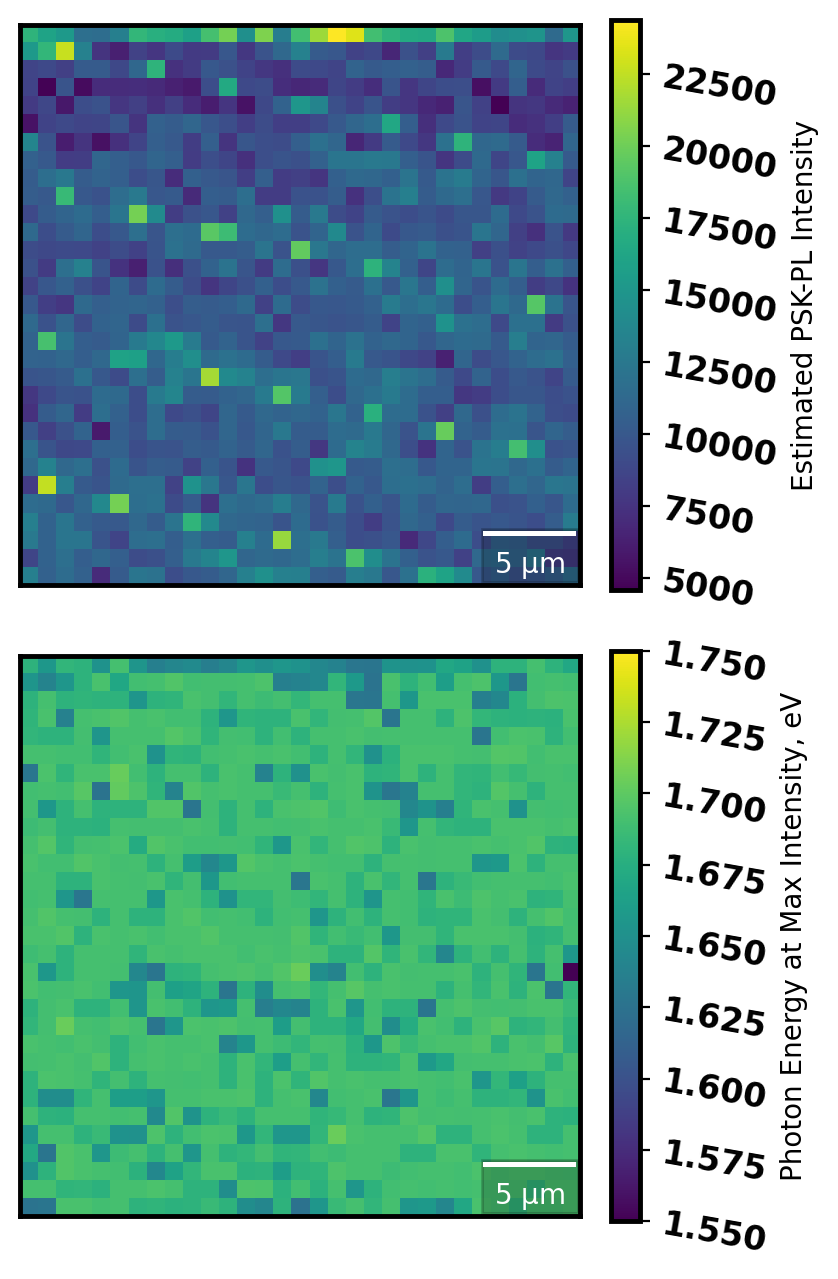

In [1119]:
vert = 2
horiz = 1
embiggen = 4


objs = ['literallyanything' for i in range(vert*horiz)]
frame = np.index_exp[25:, 25:] #to clip the data

fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen, vert*embiggen))

im = ax[0].imshow(test_2.T)#, vmin=0, vmax=40000)


# im = ax[0].imshow(test['max_pixel_smoothed'], origin='lower')

objs[0]= plt.colorbar(im, ax = ax[0], label = 'Estimated PSK-PL Intensity', fraction = 0.046)



im = ax[1].imshow(1240/test['peakPL_pixel_smoothed'].T, vmin=1.55, vmax = 1.75)


objs[1] = plt.colorbar(im, ax = ax[1], label = 'Photon Energy at Max Intensity, eV', fraction = 0.046)

for n in range(vert):
    ax[n].tick_params(left=False, bottom= False)
    ax[n].set_yticklabels([])
    ax[n].set_xticklabels([])  
    frgplt.scalebar(1e-6*(30/31), ax[n])

for n in range( len (objs)):
    plt.setp(objs[n].ax.get_yticklabels(),rotation=-10, fontsize=12, weight='black', snap=True, position=(1,0))
#     plt.setp(objs[n].set_ticks([]))
#     plt.setp(objs[n].ax.get_yticks([]))
#     plt.setp(objs[n],  vmin=0, vmax = 1 )
#     objs[n].set_ticks([])

fig.subplots_adjust(wspace=.5, hspace=.05)

plt.show()

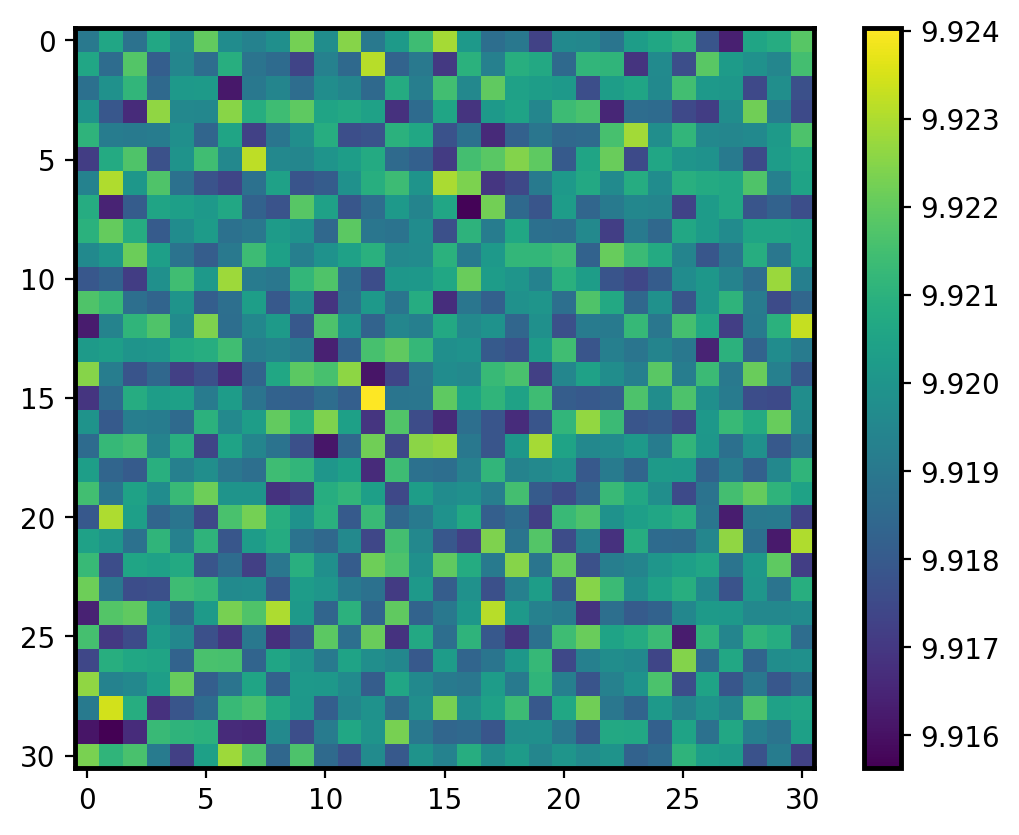

In [1046]:
plt.imshow(test['time_data'])
plt.colorbar()
plt.show()

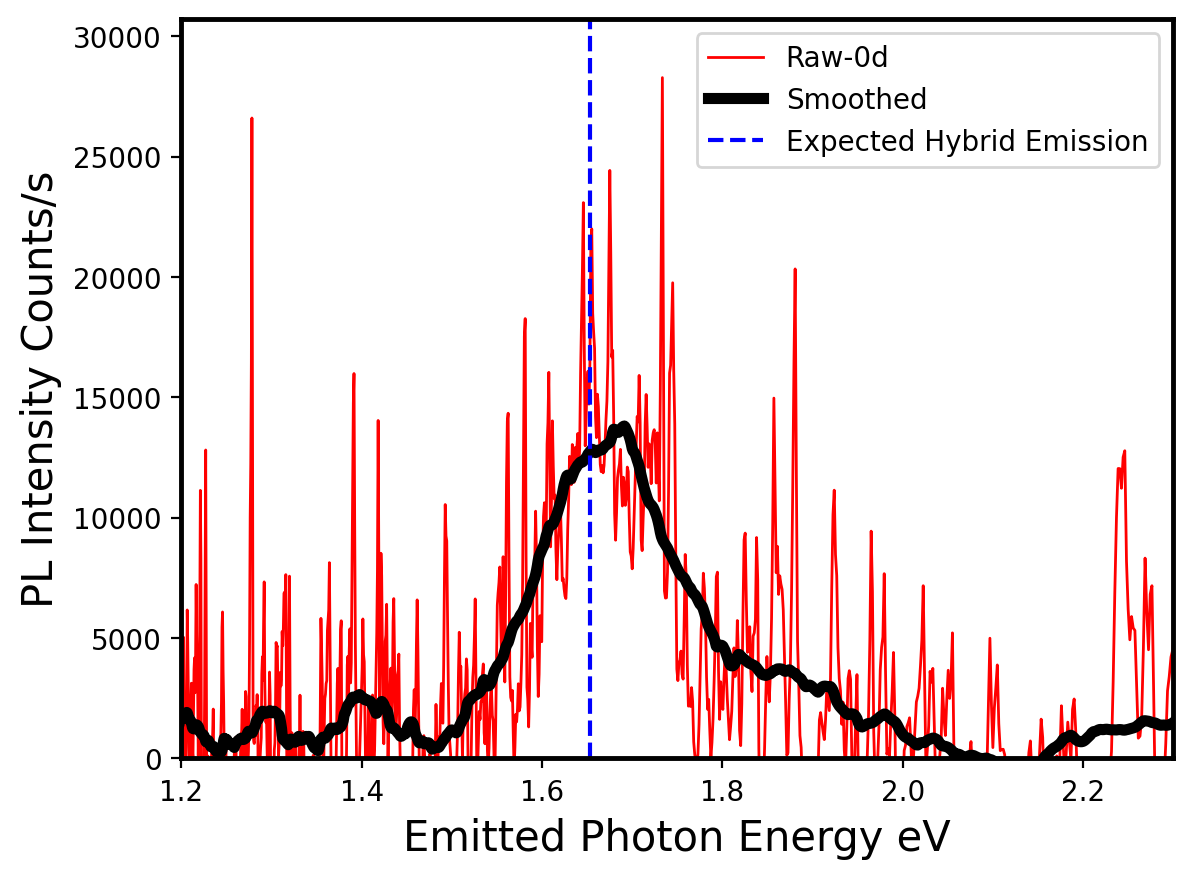

In [1121]:

# plt.plot(1240/test['energy'], test['data'][0,0,:], color='red', linewidth = '1', label='')


plt.plot(1240/test['energy'], test['data_0d'], color='red', linewidth = '1', label='Raw-0d')


# window=171

plt.plot(1240/test['energy'], test['data_0d_pixel_smoothed'], color='black', linewidth = '4', label='Smoothed')

# plt.plot(1240/test['energy'], test['data_smoothed'], color='grey', linewidth = '4', label='Smoothed', linestyle='--')

# plt.plot(1240/test['energy'], test2['data_smoothed']/np.max(test2['data_smoothed']), color='red', linewidth = '4', label='Full Scan', linestyle='--')


plt.axvline(1240/750, color = 'blue', linestyle='--', label='Expected Hybrid Emission')
# plt.axvline(1240/580, color = 'green', linestyle='--', label='Expected MAPBr Emission')

# plt.plot(1240/test['energy'], test['data_0d'], color='red', linewidth = '1')

plt.xlim(1.2,2.3)
plt.ylim(0)
plt.xlabel('Emitted Photon Energy eV', size=15)
plt.ylabel('PL Intensity Counts/s', size=15)

plt.legend()
plt.show()

In [931]:
XRF_df = pd.read_pickle('/Volumes/GoogleDrive/Shared drives/FenningLab2/Projects/APS/APS_202112_2IDD/pkl/hybrid_xeol_df')

In [932]:
XRF_df

,scannum,sample,beam_energy,xbic_scaler,dwell,x0,y0,xrange,yrange,dx,...,In_L_mol,Au_M_mol,Au_L_mol,Cs_L_mol,Pb_L_mol,Pb_M_mol,I_L_mol,Br_mol,Cl_mol,total_xrf
0,223,Hybrid-XEOL,16.4,1,10.044,998,2222,30,30,1,...,"[[0.014840647, 0.014294415, 0.014442353, 0.014...",<built-in function array>,<built-in function array>,"[[0.028386882, 0.028681595, 0.028341558, 0.028...","[[0.16033846, 0.1536002, 0.15817648, 0.1634614...",<built-in function array>,"[[0.032970447, 0.032335352, 0.032842964, 0.033...","[[0.11612232, 0.11144134, 0.11455122, 0.117650...",<built-in function array>,"[[0.35379013, 0.34138504, 0.34952688, 0.358682..."
1,224,Hybrid-XRF,16.4,1,0.146,998,2222,30,30,0.2,...,"[[0.008187415, 0.007748147, 0.0068702367, 0.00...",<built-in function array>,<built-in function array>,"[[0.013172568, 0.013874226, 0.016352193, 0.015...","[[0.08082991, 0.08069148, 0.07779241, 0.077702...",<built-in function array>,"[[0.016064374, 0.01720135, 0.016679393, 0.0185...","[[0.061904583, 0.06175562, 0.05681919, 0.05282...",<built-in function array>,"[[0.18058056, 0.18179592, 0.17493385, 0.172941..."


/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("PRGn"))


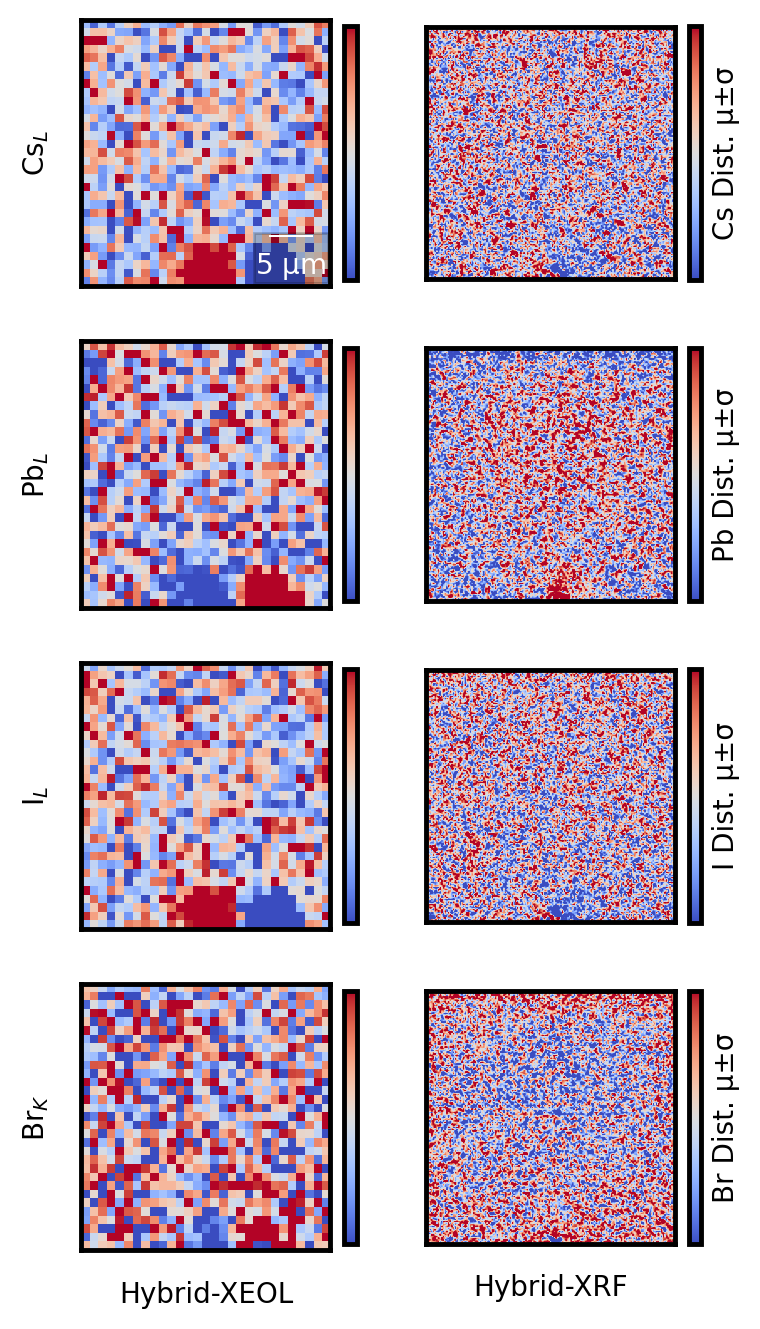

In [936]:
#for plotting XRF_WF

# dfp = df_scan_stack
dfp = XRF_df

embiggen = 2
horiz = dfp.shape[0]
vert = 4 # 7 channels + 1 ratio

# copy.copy(mpl.cm.get_cmap("coolwarm"))
cm1 = mpl.cm.get_cmap("coolwarm")
cm2 = mpl.cm.get_cmap("PRGn")

setlim = True



mpl.rcParams['axes.linewidth'] = 1.75 #set the value globally

objs = ['literallyanything' for i in range(vert*horiz)]
# n = 0
# obj_idx = int(n+n*horiz)

fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen, vert*embiggen))

cm1.set_bad(color='black')
cm2.set_bad(color='black')


# for n, ax_ in zip(range(0, len(list_of_files)), ax.ravel()):
for n, ax_ in zip(range(0, dfp.shape[0]), ax.ravel()):
    if setlim == True:
        CsL_dfp = dfp['Cs_L_mol'][n]/dfp['total_xrf'][n]
        CsL_dfp[CsL_dfp==0]=np.nan        
        im = ax_.imshow(CsL_dfp, origin='lower', vmin = (np.nanmean(CsL_dfp)-np.nanstd(CsL_dfp)), vmax = (np.nanmean(CsL_dfp)+np.nanstd(CsL_dfp)),cmap = cm1)

#         im = ax_.imshow(dfp['Cs_L_mol'][n]*mask_array_low[n]/dfp['Pb_M_mol'][n], origin='lower', vmin = np.quantile(dfp['Cs_L_mol'][n]*mask_array_low[n]/dfp['Pb_M_mol'][n],.05), vmax = np.quantile(dfp['Cs_L_mol'][n]*mask_array_low[n]/dfp['Pb_M_mol'][n],.95))
    if setlim == False:
        im = ax_.imshow(dfp['Cs_L_mol'][n]/np.quantile(dfp['Cs_L_mol'][n],.5)*mask_array_low[n]/dfp['Pb_M_mol'][n], origin='lower')
        
    if n == 0: 
        ax_.set_ylabel('Cs$_L$')       
    if n >(horiz-2):
        objs[n+horiz*0]= plt.colorbar(im, ax = ax[0,n], label = 'Cs Dist. µ±σ', fraction = 0.046)
#         objs[n+horiz*0]= plt.colorbar(im, ax = ax[0,n], label = 'Cs (mmol/cm$^2$)', fraction = 0.046)

    if n <(horiz-1):
        objs[n+horiz*0] = plt.colorbar(im, ax = ax[0,n], fraction = 0.046)
    ax_.tick_params(left=False, bottom= False)
    ax_.set_yticklabels([])
    ax_.set_xticklabels([])
#     ax_.set_yticks(rotation=90)
#     ax_.set_title('Cs_M')
#     ax_.set_xlabel(dfp['sample'][n])
    
for n, ax_ in zip(range(0, dfp.shape[0]), ax[1].ravel()):
    if setlim == True:
        
        PbL_dfp = dfp['Pb_L_mol'][n]/dfp['total_xrf'][n]
        PbL_dfp[PbL_dfp==0]=np.nan
    
        im = ax_.imshow(PbL_dfp, origin='lower', vmin = (np.nanmean(PbL_dfp)-np.nanstd(PbL_dfp)), vmax = ((np.nanmean(PbL_dfp)+np.nanstd(PbL_dfp))),cmap = cm1)
        
#         im = ax_.imshow(dfp['Pb_M_mol'][n]*mask_array_low[n], origin='lower', vmin = np.quantile(dfp['Pb_M_mol'][n]*mask_array_low[n],.05), vmax = np.quantile(dfp['Pb_M_mol'][n]*mask_array_low[n],.95))
    if setlim == False:
        im = ax_.imshow(dfp['Pb_L_mol'][n]/np.max(dfp['Pb_L_mol'][n])*mask_array_low[n], origin='lower')
    
    if n == 0: 
        ax_.set_ylabel('Pb$_L$')
    if n >(horiz-2):
        objs[n+horiz*1]= plt.colorbar(im, ax = ax[1,n], label = 'Pb Dist. µ±σ', fraction = 0.046)
    if n <(horiz-1):
        objs[n+horiz*1]= plt.colorbar(im, ax = ax[1,n], fraction = 0.046)

#     ax_.set_title('Pb_M')
#     ax_.set_xlabel(dfp['sample'][n])
    ax_.tick_params(left=False, bottom= False)

    ax_.set_yticklabels([])
    ax_.set_xticklabels([])    
    
    
for n, ax_ in zip(range(0, dfp.shape[0]), ax[2].ravel()):
    if setlim == True:
#         im = ax_.imshow(dfp['I_L_mol'][n]/np.quantile(dfp['I_L_mol'][n],.5)*mask_array_low[n]/dfp['Pb_M_mol'][n], origin='lower', vmin = I_cbar_vmin, vmax = I_cbar_vmax)


        IL_dfp = dfp['I_L_mol'][n]/dfp['total_xrf'][n]
        IL_dfp[IL_dfp==0]=np.nan

        im = ax_.imshow(IL_dfp, origin='lower', vmin = (np.nanmean(IL_dfp)-np.nanstd(IL_dfp)), vmax = (np.nanmean(IL_dfp)+np.nanstd(IL_dfp)),cmap = cm1)
    if setlim == False:
        im = ax_.imshow(dfp['I_L_mol'][n]/np.max(dfp['I_L_mol'][n])*mask_array_low[n], origin='lower')

    if n == 0: 
        ax_.set_ylabel('I$_L$')       
    if n >(horiz-2):
        objs[n+horiz*2]= plt.colorbar(im, ax = ax[2,n], label = 'I Dist. µ±σ', fraction = 0.046)
    if n <(horiz-1):
        objs[n+horiz*2]= plt.colorbar(im, ax = ax[2,n], fraction = 0.046)

#     ax_.set_title('I_L')
#     ax_.set_xlabel(dfp['sample'][n])
    ax_.tick_params(left=False, bottom= False)

    ax_.set_yticklabels([])
    ax_.set_xticklabels([])  
    
for n, ax_ in zip(range(0, dfp.shape[0]), ax[3].ravel()):
    if setlim == True:
        
        BrK_dfp = dfp['Br_mol'][n]/dfp['total_xrf'][n]
        BrK_dfp[BrK_dfp==0]=np.nan           
        
        im = ax_.imshow(BrK_dfp, origin='lower', vmin = (np.nanmean(BrK_dfp)-np.nanstd(BrK_dfp)), vmax = (np.nanmean(BrK_dfp)+np.nanstd(BrK_dfp)),cmap = cm1)
    if setlim == False:
        im = ax_.imshow(dfp['Br_mol'][n]/np.max(dfp['Br_mol'][n])*mask_array_high[n], origin='lower')

    if n == 0: 
        ax_.set_ylabel('Br$_K$') 
    if n >(horiz-2):
        objs[n+horiz*3]= plt.colorbar(im, ax = ax[3,n], label = 'Br Dist. µ±σ', fraction = 0.046)
    if n <(horiz-1):
        objs[n+horiz*3]= plt.colorbar(im, ax = ax[3,n], fraction = 0.046)

#     ax_.set_title('Cl/I')
#     ax_.set_xlabel(dfp['sample'][n], rotation=0)
    ax_.set_xlabel(dfp['sample'][n], rotation=0)
    ax_.tick_params(left=False, bottom= False)

    ax_.set_yticklabels([])
    ax_.set_xticklabels([]) 

    
 
    

frgplt.scalebar(1e-6*(30/31), ax[0,0])
# frgplt.scalebar(1e-6*.025, ax[2,2])
# frgplt.scalebar(1e-6*.025, ax[4,4])
# frgplt.scalebar(1e-6*.025, ax[0,4])
# frgplt.scalebar(1e-6*.025, ax[4,0])

# for rotating image/cbarticks
for n in range( len (objs)):
    plt.setp(objs[n].ax.get_yticklabels(),rotation=-10, fontsize=0, weight='black', snap=True, position=(0,0))
#     plt.setp(objs[n].set_ticks([]))
    objs[n].set_ticks([])
#     plt.setp(objs[n].ax.get_yticks([]))
#     plt.setp(objs[n],  vmin=0, vmax = 1 )

fig.subplots_adjust(wspace=.25, hspace=.2)

# plt.savefig('/Volumes/GoogleDrive/Shared drives/FenningLab2/Projects/APS/APS_202109_2IDD/Saved_Figures/Fitted/Inorganic/Hyb_ROIs_distributions', transparent = False, orientation='landscape', bbox_inches='tight', dpi = 1200)
plt.show()

In [965]:
CsL_dfp = np.flip(dfp['Cs_L_mol'][0]/dfp['total_xrf'][0],0)[:29, :]


In [1005]:
test_4 = 1240/test['peakPL_pixel_smoothed'].T[:29, :29]

In [1006]:
test_4_1 = test_4[10:20, 10:20]

In [964]:
test_3 = test_2.T[:29, :29]

In [990]:
CsL_dfp_1 = CsL_dfp[10:20, 10:20]

In [991]:
test_3_1 = test_3[10:20, 10:20]

In [961]:
CsL_dfp[:29, :].shape

(29, 29)

In [973]:
CsL_dfp.shape

(29, 29)

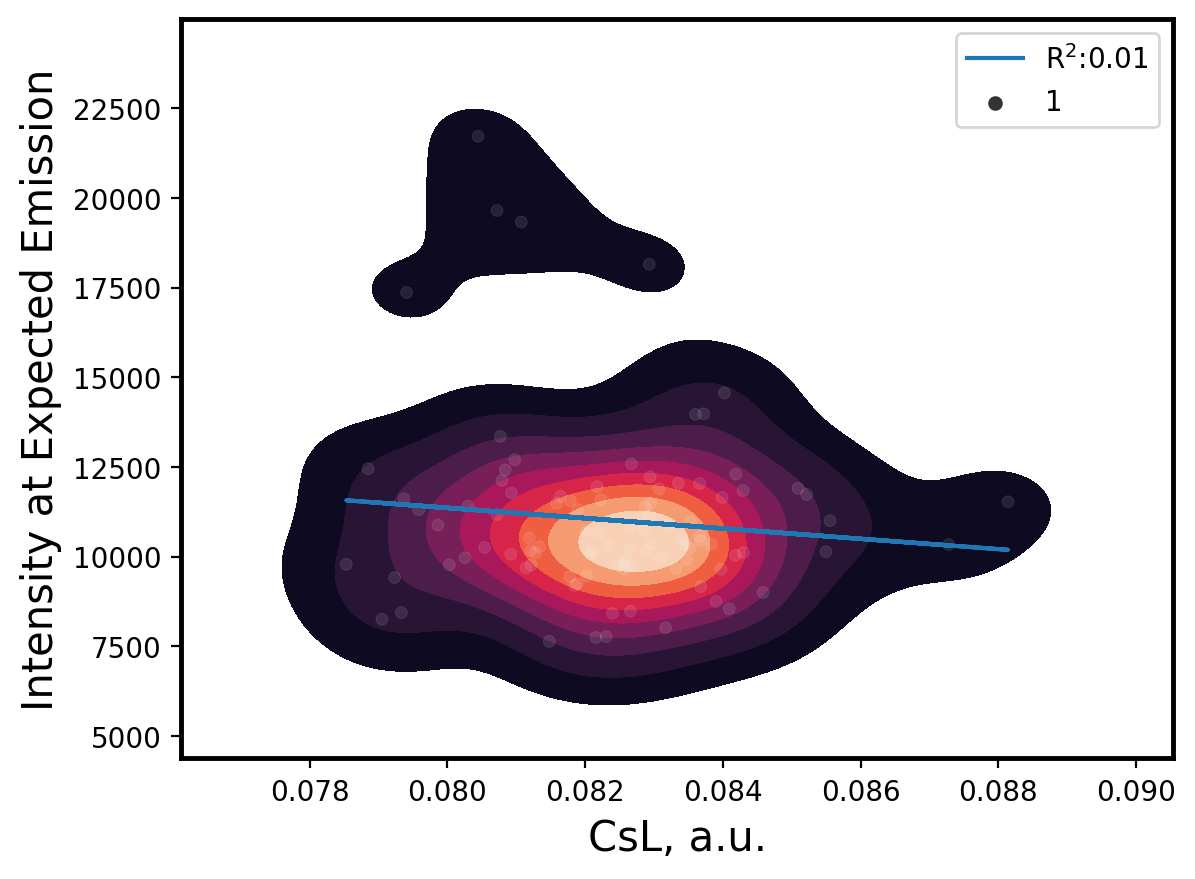

In [1013]:
fig, ax = plt.subplots()

x = CsL_dfp_1.flatten()
y = test_3_1.flatten()

sns.kdeplot(x = x, y = y,  cmap="rocket", shade=True, bw_method='scott', ax=ax)
sns.scatterplot(x = x, y = y ,ax=ax, color='w', size=1, alpha=.1)

#     sns.kdeplot(x=x[finitemask], y=y[finitemask], ax=ax[4,n], cmap="rocket", shade=True, bw_method='scott')


res = stats.linregress(x, y)
rsq = res.rvalue**2
ax.plot(x, res.intercept + res.slope*x, 'r', label=f'R$^2$:{rsq:.2f}', color='tab:blue')
ax.legend()


plt.xlabel('CsL, a.u.', size=15)
plt.ylabel('Intensity at Expected Emission', size=15)
plt.show()


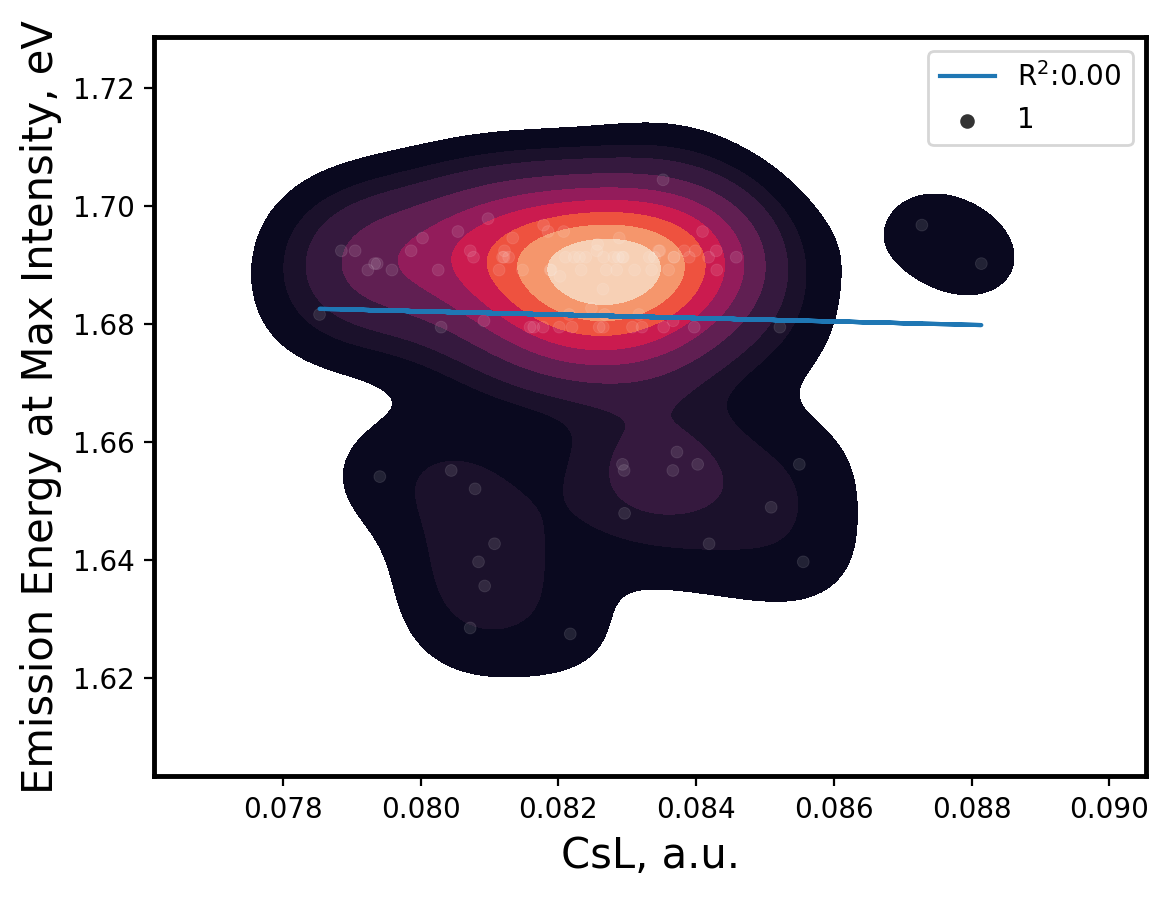

In [1012]:
fig, ax = plt.subplots()

x = CsL_dfp_1.flatten()
y = test_4_1.flatten()

sns.kdeplot(x = x, y = y,  cmap="rocket", shade=True, bw_method='scott', ax=ax)
sns.scatterplot(x = x, y = y ,ax=ax, color='w', size=1, alpha=.1)

#     sns.kdeplot(x=x[finitemask], y=y[finitemask], ax=ax[4,n], cmap="rocket", shade=True, bw_method='scott')


res = stats.linregress(x, y)
rsq = res.rvalue**2
ax.plot(x, res.intercept + res.slope*x, 'r', label=f'R$^2$:{rsq:.2f}', color='tab:blue')
ax.legend()


plt.xlabel('CsL, a.u.', size = 15)
plt.ylabel('Emission Energy at Max Intensity, eV', size=15)
plt.show()


In [369]:
# scan_x_points = 5
# scan_y_points = 36
dwell_time = 10
scan_x_points **2 * dwell_time/60/60
time_goal = 20

num_points = np.sqrt((time_goal*60)/dwell_time)
num_points

7.745966692414834

In [370]:
2.5*8

20.0

In [466]:
np.round(points**2*dwell_time/3600,2)

2.67

In [472]:
dwell_time = 11
points = 31

print(str(np.round(points**2*dwell_time/3600,2))+str(' hours'))

2.94 hours


In [238]:
left_cutoff = 1300
right_cutoff = 250

x_test = 1240/test['energy'][:left_cutoff]
x_test = x_test[right_cutoff:]

y_test = test['data_smoothed'][:left_cutoff]
y_test = y_test[right_cutoff:]

# plt.xlim(x_test[-1], x_test[0])

y_test[y_test<0] = 0
# plt.plot(x_test, y_test)
# y_test = y_test_bg
# plt.show()

In [239]:
X_test,Y_test = x_test, y_test 

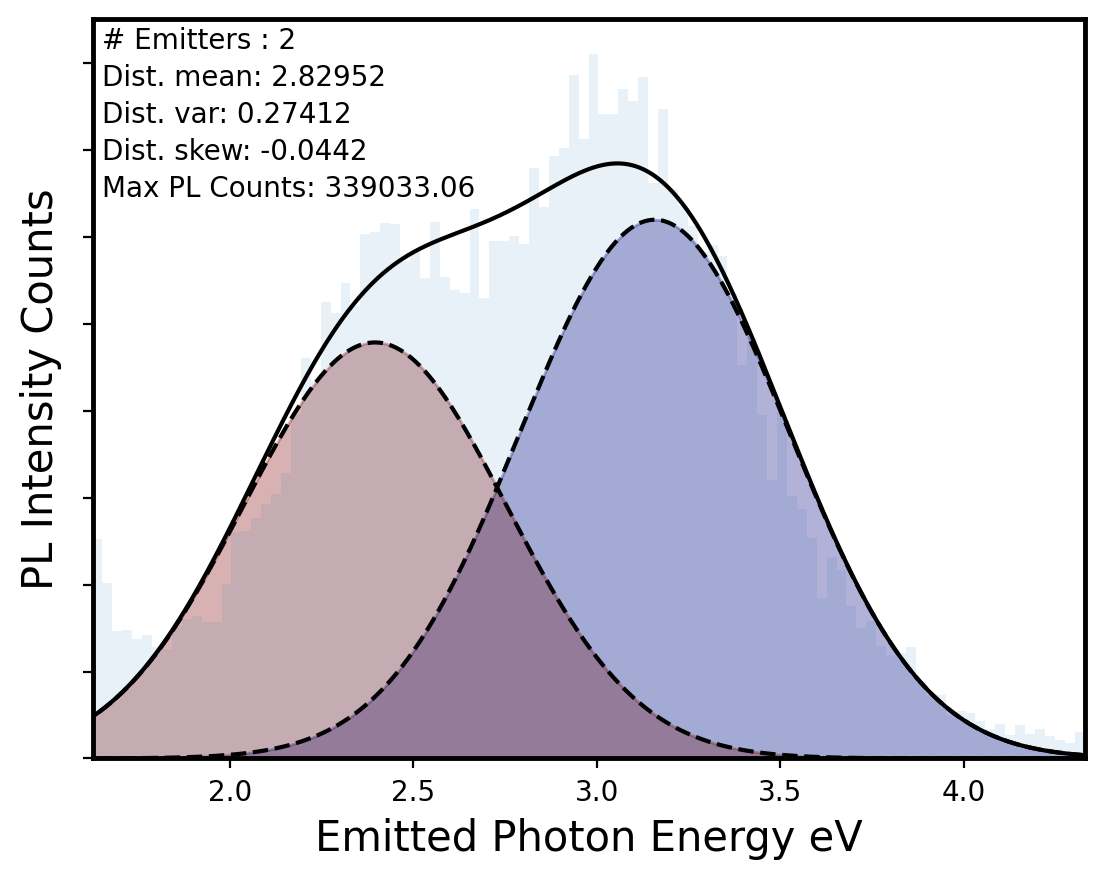

In [240]:
from numpy.random import choice
from scipy.stats import skew
from sklearn.mixture import GaussianMixture

N_components = 2
draw_N = 100000
draw = choice(X_test, draw_N, p=Y_test/np.sum(Y_test))
draw = draw.reshape(-1,1)

draw_mean = np.mean(draw)
draw_var = np.var(draw)
draw_skew= skew(draw)[0]

X = draw

random_state = np.random.RandomState(seed=1)

N = np.arange(1, N_components+1)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

# colors = ''
colors = plt.cm.jet(np.linspace(0,1,len(N)))

embiggen = 5
horiz = 1
vert = 1
objs = ['literallyanything' for i in range(vert*horiz)]

fig, ax = plt.subplots()#vert, horiz, figsize = (horiz*embiggen*1.4, vert*embiggen))
M_best = models[np.argmin(AIC)]

# x = np.linspace(-6, 6, 1000)
# logprob = M_best.score_samples(x.reshape(-1, 1))
# responsibilities = M_best.predict_proba(x.reshape(-1, 1))

x = X_test
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))



pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 100, density=True, histtype='stepfilled', alpha=0.1)


ax.plot(x, pdf, '-k')

ax.plot(x, pdf_individual, '--k')
for n in range(0,len(N)):
    ax.fill_between(x, 0, pdf_individual[:,n], alpha=0.3, color = colors[n])

    
ax.set_xlim(x[-1], x[0])
ax.set_xlabel('Emitted Photon Energy eV', size=15)
ax.set_ylabel('PL Intensity Counts', size=15)


ax.text(0.01, .99, s = ('# Emitters : '+ str(np.round(N_components,0))), horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
ax.text(0.01, .94, s = ('Dist. mean: '+ str(np.round(draw_mean,5))), horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
ax.text(0.01, .89, s = ('Dist. var: '+ str(np.round(draw_var,5))), horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
ax.text(0.01, .84, s = ('Dist. skew: '+ str(np.round(draw_skew,5))), horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
ax.text(0.01, .79, s = ('Max PL Counts: '+ str(np.round(np.max(Y_test),2))), horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)


ax.set_yticklabels([])


plt.show()

In [643]:
#taking center 2/3
small = int(np.min(test['data'].shape[0])/2-np.round(np.min(test['data'].shape[0])/3,0))
big = int(np.min(test['data'].shape[0])/2+np.round(np.min(test['data'].shape[0])/3,0))
